# Modeling and Simulation in Python

Chapter 6: Analysis

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# To switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

### Code from the previous chapter

`make_system`, `plot_results`, and `calc_total_infected` are unchanged.

In [2]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= np.sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [3]:
def plot_results(S, I, R):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', color='blue', label='Susceptible')
    plot(I, '-', color='red', label='Infected')
    plot(R, ':', color='green', label='Resistant')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

In [4]:
def calc_total_infected(system):
    """Fraction of population infected during the simulation.
    
    system: System object with results.
    
    returns: fraction of population
    """
    frame = system.results
    return frame.S[system.t0] - frame.S[system.t_end]

Here's an updated version of `run_simulation` that uses `unpack`.

In [5]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.loc[t0] = init
    
    for i in linrange(t0, t_end):
        frame.loc[i+1] = update_func(frame.loc[i], system)
    
    system.results = frame

**Exercise:** Write a version of `update1` that uses `unpack`.

In [6]:
# Original

def update1(state, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    system: System object
    
    returns: State (sir)
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [7]:
def update1unpacked(state, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    system: System object
    
    returns: State (sir)
    """
    s, i, r = state
    
    unpack(system)

    infected = beta * i * s    
    recovered = gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

Test the updated code with this example.

In [8]:
system = make_system(0.333, 0.25)
run_simulation(system, update1unpacked)
system.results.head()

,S,I,R
0,0.988889,0.011111,0.000000
1,0.985230,0.011992,0.002778
2,0.981296,0.012929,0.005776
3,0.977071,0.013921,0.009008
4,0.972541,0.014970,0.012488


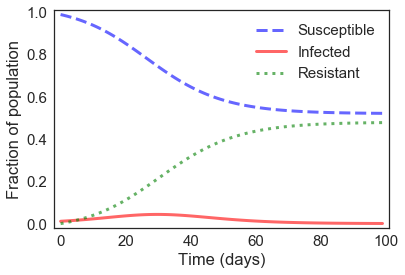

In [9]:
frame = system.results
plot_results(frame.S, frame.I, frame.R)

### Sweeping beta

Make a range of values for `beta`, with constant `gamma`.

In [10]:
beta_array = linspace(0.1, 0.9, 11)
gamma = 0.25

Run the simulation once for each value of `beta` and print total infections.

In [11]:
for beta in beta_array:
    system = make_system(beta, gamma)
    run_simulation(system, update1)
    print(system.beta, calc_total_infected(system))

0.1 0.00723090166498
0.18 0.0262722567457
0.26 0.160575485321
0.34 0.490862856866
0.42 0.689867847411
0.5 0.804506112463
0.58 0.873610307851
0.66 0.916554007142
0.74 0.943729262152
0.82 0.961060480958
0.9 0.972099315633


Wrap that loop in a function and return a `SweepSeries` object.

In [12]:
def sweep_beta(beta_array, gamma):
    """SweepSeriess a range of values for beta.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    sweep = SweepSeries()
    for beta in beta_array:
        system = make_system(beta, gamma)
        run_simulation(system, update1)
        sweep[system.beta] = calc_total_infected(system)
    return sweep

SweepSeries `beta` and plot the results.

In [13]:
infected_sweep = sweep_beta(beta_array, gamma)

Saving figure to file chap06-fig01.pdf


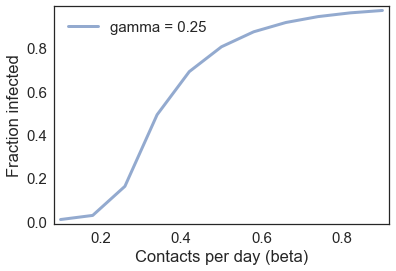

In [14]:
label = 'gamma = ' + str(gamma)
plot(infected_sweep, label=label)
decorate(xlabel='Contacts per day (beta)',
         ylabel='Fraction infected')

savefig('chap06-fig01.pdf')

### Sweeping gamma

Using the same array of values for `beta`

In [15]:
beta_array = linspace(0.1, 0.9, 11)
beta_array

array([ 0.1 ,  0.18,  0.26,  0.34,  0.42,  0.5 ,  0.58,  0.66,  0.74,
        0.82,  0.9 ])

And now an array of values for `gamma`

In [16]:
gamma_array = linspace(0.1, 0.7, 4)
gamma_array

array([ 0.1,  0.3,  0.5,  0.7])

For each value of `gamma`, SweepSeries `beta` and plot the results.

Saving figure to file chap06-fig02.pdf


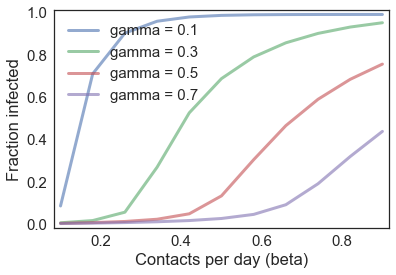

In [17]:
for gamma in gamma_array:
    infected_sweep = sweep_beta(beta_array, gamma)
    label = 'gamma = ' + str(gamma)
    plot(infected_sweep, label=label)
    
decorate(xlabel='Contacts per day (beta)',
         ylabel='Fraction infected',
         loc='upper left')

savefig('chap06-fig02.pdf')

Now wrap that loop in a function and store the results in a `SweepSeriesFrame`

In [18]:
def sweep_parameters(beta_array, gamma_array):
    """SweepSeriess a range of values for beta and gamma.
    
    beta_array: array of infection rates
    gamma_array: array of recovery rates
    
    returns: SweepSeriesFrame with one row for each beta
             and one column for each gamma
    """
    frame = SweepFrame(columns=gamma_array)
    for gamma in gamma_array:
        frame[gamma] = sweep_beta(beta_array, gamma)
    return frame

Here's what the results look like.

In [19]:
frame = sweep_parameters(beta_array, gamma_array)
frame.head()

,0.1,0.3,0.5,0.7
0.10,0.084693,0.005444,0.002736,0.001827
0.18,0.708623,0.015914,0.006118,0.003783
0.26,0.900780,0.055380,0.011639,0.006427
0.34,0.956888,0.267864,0.022115,0.010191
0.42,0.977045,0.524563,0.047816,0.015946


And here's how we can plot the results.

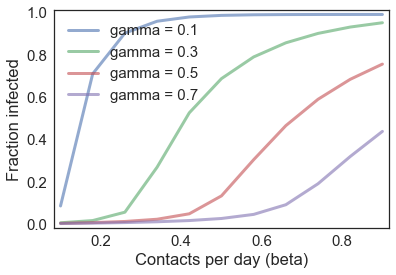

In [20]:
for gamma in gamma_array:
    label = 'gamma = ' + str(gamma)
    plot(frame[gamma], label=label)
    
decorate(xlabel='Contacts per day (beta)',
         ylabel='Fraction infected',
         loc='upper left')

It's often useful to separate the code that generates results from the code that plots the results, so we can run the simulations once, save the results, and then use them for different analysis, visualization, etc.

### Contact number

After running the SweepSeriess, we have a `SweepSeriesFrame` with one row for each value of `beta` and one column for each value of `gamma`.

In [21]:
frame.shape

(11, 4)

The following loop shows how we can loop through the columns and rows of the `SweepSeriesFrame`.  With 11 rows and 4 columns, there are 44 elements.

One implementation note: when we select a column from a `SweepSeriesFrame` we get a `Series` object, rather than a `SweepSeries` object, but they are almost the same.

In [22]:
for gamma in frame.columns:
    series = frame[gamma]
    for beta in series.index:
        frac_infected = series[beta]
        print(beta, gamma, frac_infected)

0.1 0.1 0.0846929424381
0.18 0.1 0.70862278537
0.26 0.1 0.900780251778
0.34 0.1 0.956887899544
0.42 0.1 0.977045257074
0.5 0.1 0.984595862826
0.58 0.1 0.987400345318
0.66 0.1 0.988404249064
0.74 0.1 0.988743421406
0.82 0.1 0.988849515052
0.9 0.1 0.988879570517
0.1 0.3 0.00544355912239
0.18 0.3 0.0159140691448
0.26 0.3 0.0553797621068
0.34 0.3 0.267864167733
0.42 0.3 0.524562935844
0.5 0.3 0.686050483916
0.58 0.3 0.788378556339
0.66 0.3 0.85506574641
0.74 0.3 0.89947913569
0.82 0.3 0.929469302619
0.9 0.3 0.949853310327
0.1 0.5 0.00273576554115
0.18 0.5 0.00611834135832
0.26 0.5 0.0116394693217
0.34 0.5 0.0221147665242
0.42 0.5 0.0478162266689
0.5 0.5 0.132438038458
0.58 0.5 0.303264192648
0.66 0.5 0.464110227319
0.74 0.5 0.588476972528
0.82 0.5 0.682749610978
0.9 0.5 0.754595298329
0.1 0.7 0.001826769347
0.18 0.7 0.00378256160842
0.26 0.7 0.00642667221076
0.34 0.7 0.0101905519335
0.42 0.7 0.0159458265615
0.5 0.7 0.0257079250464
0.58 0.7 0.0450077531168
0.66 0.7 0.0906940688294
0.74 0.7 

Now we can wrap that loop in a function and plot the results.  For each element of the `SweepSeriesFrame`, we have `beta`, `gamma`, and `frac_infected`, and we plot `beta/gamma` on the x-axis and `frac_infected` on the y-axis.

In [23]:
def plot_sweep_frame(frame):
    """Plots the values from a parameter SweepSeries.
    
    For each (beta, gamma), computes the contact number,
    beta/gamma
    
    frame: SweepFrame with one row per beta, one column per gamma
    """
    for gamma in frame.columns:
        series = frame[gamma]
        for beta in series.index:
            frac_infected = series[beta]
            plot(beta/gamma, frac_infected, 'ro',
                 label='Simulation')

Here's what it looks like:

Saving figure to file chap06-fig03.pdf


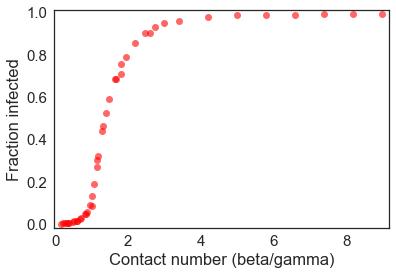

In [24]:
plot_sweep_frame(frame)

decorate(xlabel='Contact number (beta/gamma)',
         ylabel='Fraction infected',
         legend=False)

savefig('chap06-fig03.pdf')

It turns out that the ratio `beta/gamma`, called the "contact number" is sufficient to predict the total number of infections; we don't have to know `beta` and `gamma` separately.

We can see that in the previous plot: when we plot the fraction infected versus the contact number, the results fall close to a curve.

But if we didn't know about the contact number, we might have explored other possibilities, like the difference between `beta` and `gamma`, rather than their ratio.

**Exercise:**  Write a version of `plot_sweep_frame`, called `plot_sweep_frame_difference`, that plots the fraction infected versus the difference `beta-gamma`.

What do the results look like, and what does that imply? 

In [27]:
def plot_sweep_frame_difference(frame):
    """Plots the values from a parameter SweepSeries.
    
    For each (beta, gamma), computes the contact number,
    beta/gamma
    
    frame: SweepFrame with one row per beta, one column per gamma
    """
    for gamma in frame.columns:
        series = frame[gamma]
        for beta in series.index:
            frac_infected = series[beta]
            plot(beta-gamma, frac_infected, 'ro',
                 label='Simulation')

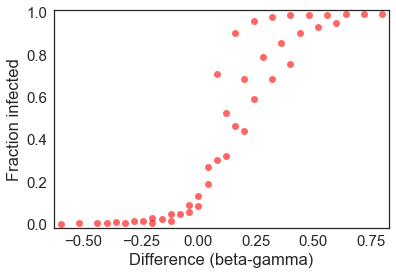

In [30]:
plot_sweep_frame_difference(frame)

decorate(xlabel='Difference (beta-gamma)',
         ylabel='Fraction infected',
         legend=False)

#The results show that the greater the difference between beta and gamma, the more people will become infected.

### Analysis

In the book we figured out the relationship between $c$ and $s_{\infty}$ analytically.  Now we can compute it for a range of values:

In [31]:
s_inf_array = linspace(0.0001, 0.9999, 101)
#s_inf_array

In [32]:
c_array = log(s_inf_array) / (s_inf_array - 1)
#c_array

`total_infected` is the change in $s$ from the beginning to the end.

In [33]:
frac_infected = 1 - s_inf_array
frac_infected_series = Series(frac_infected, index=c_array)

Now we can plot the analytic results and compare them to the simulations.

Saving figure to file chap06-fig04.pdf


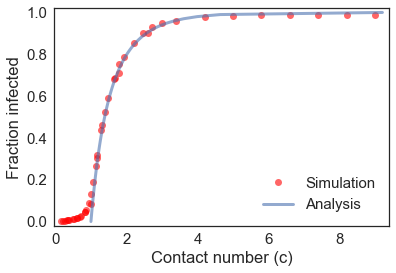

In [34]:
plot_sweep_frame(frame)
plot(frac_infected_series, label='Analysis')

decorate(xlabel='Contact number (c)',
         ylabel='Fraction infected')

savefig('chap06-fig04.pdf')

The agreement is generally good, except for values of `c` less than 1.

**Exercise:** Suppose you run a survey at the end of the semester and find that 26% of students had the Freshman Plague at some point.  What is your best estimate of `c`?

Hint: if you print `frac_infected_series`, you can read off the answer. 

In [36]:
print(frac_infected_series)
#for Fraction infected=26%, c=1.158

9.211261    0.999900
4.642296    0.989902
3.987365    0.979904
3.612133    0.969906
3.350924    0.959908
3.151808    0.949910
2.991711    0.939912
2.858363    0.929914
2.744467    0.919916
2.645332    0.909918
2.557767    0.899920
2.479505    0.889922
2.408879    0.879924
2.344627    0.869926
2.285771    0.859928
2.231541    0.849930
2.181315    0.839932
2.134590    0.829934
2.090947    0.819936
2.050040    0.809938
2.011573    0.799940
1.975299    0.789942
1.941002    0.779944
1.908499    0.769946
1.877628    0.759948
1.848249    0.749950
1.820238    0.739952
1.793487    0.729954
1.767898    0.719956
1.743384    0.709958
              ...   
1.181034    0.290042
1.173263    0.280044
1.165630    0.270046
1.158132    0.260048
1.150765    0.250050
1.143524    0.240052
1.136407    0.230054
1.129409    0.220056
1.122527    0.210058
1.115758    0.200060
1.109099    0.190062
1.102547    0.180064
1.096099    0.170066
1.089751    0.160068
1.083503    0.150070
1.077350    0.140072
1.071291    0

In [37]:
# Alternative solution

"""We can use `np.interp` to look up `s_inf` and
estimate the corresponding value of `c`, but it only
works if the index of the series is sorted in ascending
order.  So we have to use `sort_index` first.
"""

frac_infected_series.sort_index(inplace=True)
np.interp(0.26, frac_infected_series, frac_infected_series.index)

1.158096819542062